In [1]:
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

import logging
from linkedin_jobs_scraper import LinkedinScraper
from linkedin_jobs_scraper.events import Events, EventData
from linkedin_jobs_scraper.query import Query, QueryOptions, QueryFilters
from linkedin_jobs_scraper.filters import RelevanceFilters, TypeFilters

# Data Science skills

How to identifiy the most in-demand skills for a data scientist? 

To answer this question I looked at the job postings on *LinkedIn* with vacant positions for data scientists in Austria. The job description was searched for the following terms:
* Python
* R
* SQL
* noSQL
* Excel
* Power BI
* Tableau
* TensorFlow
* PyTorch
* Spark
* Hadoop
* AWS
* Azure

Feel free to change these keywords, the job title or the location in the [parameters](#parameters) section. 

The [Results](#results) show that the three most requested skills are the two programming languages **R** and **Python** as well as the query language **SQL**.

---

Requirements
* Python v3.10
* Beautifulsoup4 v4.11.1
* Matplotlib v3.5.2
* Linkedin-jobs-scraper v1.15.2 (needs [ChromeDriver](https://chromedriver.chromium.org/))

## Parameters
<a id="parameters"></a>

In [2]:
# Parameters
job = "Data Science"
locations = ["Austria"]
keywords = ("Python", "R", "SQL", "noSQL", "Excel", "PowerBI", "Power BI", "Tableau", "TensorFlow", "PyTorch", "Spark", "Hadoop", "AWS", "Azure")

## Code

In [ ]:
# Change root logger level (default is WARN)
logging.basicConfig(level = logging.INFO)
job_postings = []

# Fired once for each successfully processed job
def on_data(data: EventData):
    job_postings.append(data.link)

scraper = LinkedinScraper(
    chrome_executable_path=None,
    chrome_options=None,
    headless=True,
    max_workers=1,
    slow_mo=3,    # Slow down the scraper to avoid 'Too many requests 429' errors (in seconds)
    page_load_timeout=20 
)

# Add event listeners
scraper.on(Events.DATA, on_data)

queries = [
    Query(
        query=job,
        options=QueryOptions(
            locations=locations,
            limit=500,
            filters=QueryFilters(
                relevance=RelevanceFilters.RECENT,
                type=[TypeFilters.FULL_TIME]              
            )
        )
    ),
]

scraper.run(queries)

In [22]:
# Check in how many job descriptions the keywords occur
counts = {keyword: 0 for keyword in keywords}
n_postings = 0

for url in job_postings:
    response = requests.get(url) 
    soup = BeautifulSoup(response.text, "html.parser")
    job_description = soup.find_all("div", {"class": "description__text"})
    # Skip postings that have no job description
    if len(job_description) > 0:
        n_postings += 1
        text = job_description[0].get_text()
        for key in counts.keys():
            key_space = key.center(len(key) + 2)        # Search for seperated keywords
            key_comma = key.ljust(len(key) + 1, ",")    # Search for keywords in an enumeration
            key_slash = key.ljust(len(key) + 1, "/")    # Search for keywords seperated by a slash
            count_key_space = text.lower().count(key_space.lower())
            count_key_comma = text.lower().count(key_comma.lower())
            count_key_slash = text.lower().count(key_slash.lower())
            if count_key_space > 0 or count_key_comma > 0 or count_key_slash > 0: 
                counts[key] += 1

# Combine "PowerBI" and "Power BI"
if all(x in keywords for x in ["PowerBI", "Power BI"]):
    counts["PowerBI"] += counts["Power BI"]
    del counts["Power BI"]

## Results
<a id="results"></a>

In [23]:
# Results
print("{} job postings searched:".format(n_postings))
print(counts)

381 job postings searched:
{'Python': 143, 'R': 261, 'SQL': 100, 'noSQL': 15, 'Excel': 32, 'PowerBI': 54, 'Tableau': 38, 'TensorFlow': 15, 'PyTorch': 11, 'Spark': 30, 'Hadoop': 19, 'AWS': 47, 'Azure': 40}


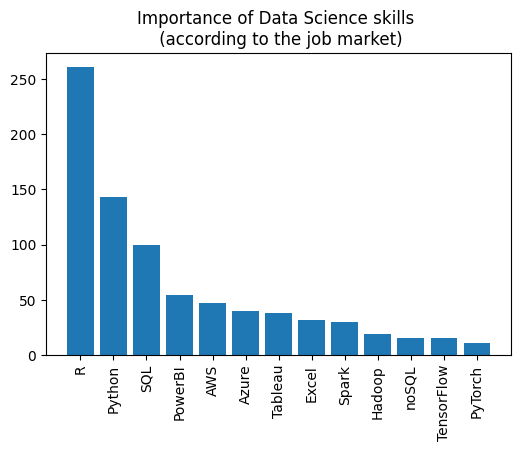

In [24]:
# Plot
sorted_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
fig, ax = plt.subplots()
fig.set_dpi(100)
ax.bar(sorted_counts.keys(), sorted_counts.values())
plt.title("Importance of Data Science skills \n (according to the job market)")
plt.xticks(rotation=90)
plt.show()